## Evaluation Calibration and timeconstant measurements Tsensors

In [215]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as colors
import io
import glob
from pandas.tseries.offsets import DateOffset

### Load all the data files

['Tsensor_measurements/TSENSOR_SimonS.LOG', 'Tsensor_measurements/TSENSOR_QR.LOG', 'Tsensor_measurements/TSENSOR_LG.LOG', 'Tsensor_measurements/TSENSOR_DF.LOG', 'Tsensor_measurements/TSENSOR_KiS.LOG', 'Tsensor_measurements/TSENSOR_KS.LOG', 'Tsensor_measurements/TSENSOR_KM.LOG', 'Tsensor_measurements/TSENSOR_DKB.LOG']


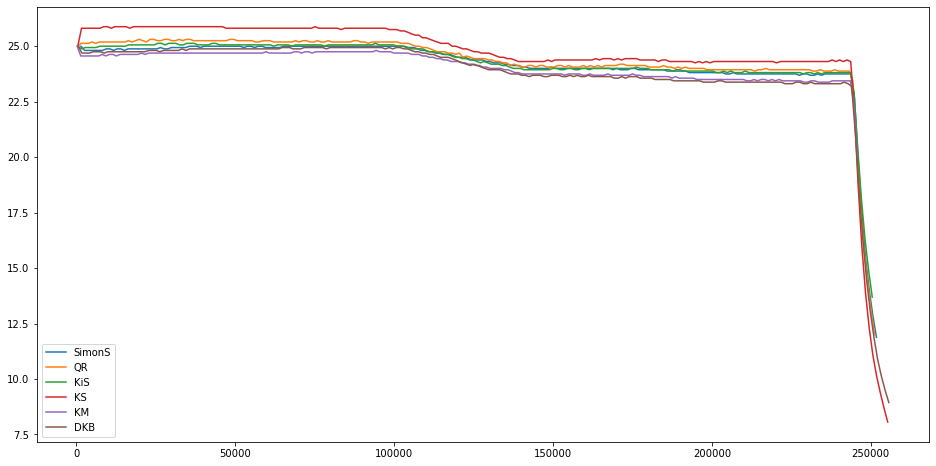

In [216]:
#1. Read in the dataframes and merge then into one dataframe
filenames = glob.glob("Tsensor_measurements/*.LOG")
print(filenames)
filenames = filenames[:2] + filenames[4:]

fig=plt.figure(figsize=(16,8))
for filename in filenames:
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    plt.plot(tsensor["millis"][:220], tsensor["temperature"][:220], label = filename.split("/")[-1].split("_")[-1].split(".")[0])
    plt.legend()
#dfs = []
#for filename in filenames:
#    dfs.append(pd.read_csv(filename, sep=',', comment='#',names=["time","group","spot","average"]))

# Concatenate all data into one DataFrame
#big_frame = pd.concat(dfs, ignore_index=True)

#Convert to datetime
#big_frame['time'] = pd.to_datetime(big_frame['time'])

#sort dateframe by date:
#big_frame.sort_values(by='time', inplace=True)

#set index to time
#big_frame.set_index(['time'], inplace=True)

#big_frame.head(16)

['Tsensor_measurements/TSENSOR_SimonS.LOG', 'Tsensor_measurements/TSENSOR_QR.LOG', 'Tsensor_measurements/TSENSOR_LG.LOG', 'Tsensor_measurements/TSENSOR_DF.LOG', 'Tsensor_measurements/TSENSOR_KiS.LOG', 'Tsensor_measurements/TSENSOR_KS.LOG', 'Tsensor_measurements/TSENSOR_KM.LOG', 'Tsensor_measurements/TSENSOR_DKB.LOG']
millis start:  212
SimonS   temp start:  23.74225806451613
SimonS   temp end:  2.383870967741935
SimonS   Temp tau:  10.24118247722657
SimonS   time tau:  254087
millis start:  212
QR   temp start:  23.922580645161293
QR   temp end:  2.719032258064516
QR   Temp tau:  10.519381789561315
QR   time tau:  253493
millis start:  217
LG   temp start:  24.04
LG   temp end:  2.893225806451612
LG   Temp tau:  10.672689279352872
LG   time tau:  262366
millis start:  211
DF   temp start:  24.05612903225805
DF   temp end:  3.0783870967741938
DF   Temp tau:  10.795667077038726
DF   time tau:  250921
millis start:  213
KiS   temp start:  23.806451612903214
KiS   temp end:  2.436129032258

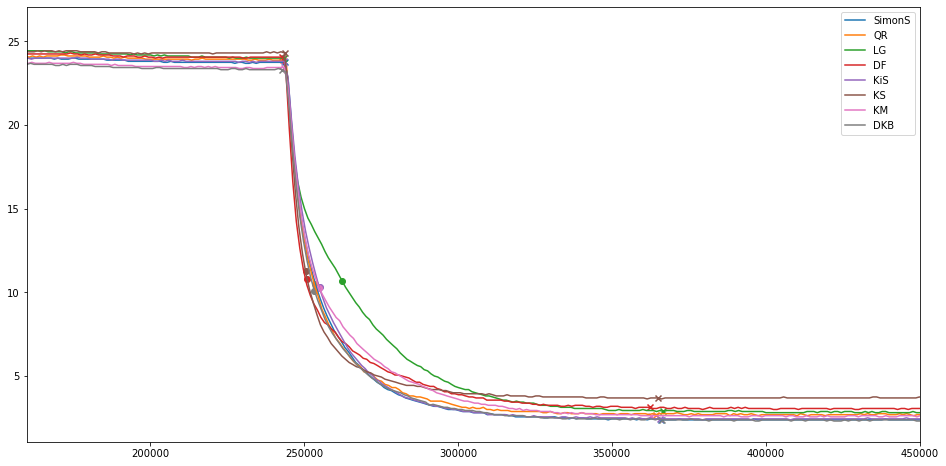

In [218]:
filenames = glob.glob("Tsensor_measurements/*.LOG")
print(filenames)

fig=plt.figure(figsize=(16,8))
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
              '#7f7f7f', '#bcbd22', '#17becf']
i=0
millis_start = np.zeros(8, int)
for filename in filenames:
    #load in all file by file
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    
    #calculate temporal changes:
    diff = tsensor['temperature'].values[1:] - tsensor['temperature'].values[:-1]
    
    #find index of value that is closest to 200000ms
    diff_200000 = abs(tsensor['millis']-200000)
    millis_200000 = np.where(diff_200000 == min(diff_200000))[0][0]
    
    #find "start time", where temporal temperature change is larger than 0.1°C
    millis_start[i] = np.where(abs(diff[millis_200000:350]) >= 0.1)[0][0] + millis_200000
    start_time = tsensor['millis'][millis_start[i]]
    print('millis start: ', millis_start[i])
    
    #find "end time", where temporan temperature change over an interval of 60s is smaller than 0.1°C
    sum_diff = np.zeros(len(diff))
    n= 100 ##average time
    for k in range(len(diff)-n):
        sum_diff[k+n-1] = np.nanmean(diff[k:k+n-1])
    
    millis_end = np.where(abs(sum_diff[millis_start[i]+n:]) <= 0.1)[0][0]
    end_time = tsensor['millis'][millis_start[i]+millis_end+n]  
    #print('end time: ', end_time)
    
    ##find start and end temperature by averaging over 30s:
    temp_start = np.mean(tsensor['temperature'].values[millis_start[i]-30:\
                                                       millis_start[i]+1])
    print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   temp start: ', temp_start)
    temp_end = np.mean(tsensor['temperature'].values[millis_start[i]+millis_end+n:\
                                                     millis_start[i]+millis_end+n+31])
    print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   temp end: ',temp_end)
    
    ##calculate temperature and time constant
    Temp_tau = temp_end + 1/np.e *(temp_start - temp_end)
    print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   Temp tau: ',Temp_tau)
    diff_temp = abs(tsensor['temperature'].values[:330] - Temp_tau)
    time_tau = tsensor['millis'].values[np.where(diff_temp == min(diff_temp))[0][0]]
    print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   time tau: ',time_tau)
    
    
    #plot of the sensors:
    plt.plot(tsensor["millis"], tsensor["temperature"], c=c[i], label = filename.split("/")[-1].
             split("_")[-1].split(".")[0])
    plt.scatter(start_time, tsensor['temperature'].values[millis_start[i]],c = c[i], marker='x')
    plt.scatter(end_time, tsensor['temperature'].values[millis_start[i]+millis_end+n], c=c[i],
                marker='x')
    plt.scatter(time_tau, Temp_tau)
    plt.legend()
    plt.xlim(160000,450000)
    
    i += 1

## Calibration

In [219]:
millis_start

array([212, 212, 217, 211, 213, 209, 217, 208])

In [220]:
calibration = pd.read_csv('Tsensor_measurements/tsensor_calibration_time_constant.log', comment='#',
                          names=["time","temperature"])
calibration['time']= pd.to_datetime(calibration["time"], utc=True).dt.tz_localize(None)
start_shock = calibration['time'].values[2]
start_shock

numpy.datetime64('2023-03-02T15:52:04.000000000')

In [221]:
calibration

,time,temperature
0,2023-03-02 15:49:56,24.38
1,2023-03-02 15:51:51,23.53
2,2023-03-02 15:52:04,7.60
3,2023-03-02 15:52:38,3.90
4,2023-03-02 15:52:43,3.30
5,2023-03-02 15:52:53,2.90
6,2023-03-02 15:53:03,2.70
7,2023-03-02 15:53:13,2.60
8,2023-03-02 15:53:23,2.50
9,2023-03-02 15:53:33,2.45


In [222]:
calibration_2 = pd.read_csv('Tsensor_measurements/tsensor_calibration.log', sep=',', comment='#',names=["time","millis","ID","temperature"])
calibration_2["time"] = pd.to_datetime(calibration_2["time"], utc=True).dt.tz_localize(None)

In [223]:
calibration_2

,time,millis,ID,temperature
0,2023-03-02 16:01:53,0,Labor,3.00
1,2023-03-02 16:03:53,0,Labor,4.00
2,2023-03-02 16:05:30,0,Labor,5.00
3,2023-03-02 16:06:54,0,Labor,6.00
4,2023-03-02 16:08:16,0,Labor,7.04
5,2023-03-02 16:09:36,0,Labor,8.00
6,2023-03-02 16:10:50,0,Labor,9.00
7,2023-03-02 16:12:11,0,Labor,10.00
8,2023-03-02 16:13:37,0,Labor,11.00
9,2023-03-02 16:15:10,0,Labor,12.00


Tsensor_measurements/TSENSOR_SimonS.LOG', 'Tsensor_measurements/TSENSOR_QR.LOG', 'Tsensor_measurements/TSENSOR_LG.LOG', 'Tsensor_measurements/TSENSOR_DF.LOG', 'Tsensor_measurements/TSENSOR_KiS.LOG', 'Tsensor_measurements/TSENSOR_KS.LOG', 'Tsensor_measurements/TSENSOR_KM.LOG', 'Tsensor_measurements/TSENSOR_DKB.LOG']

['Tsensor_measurements/TSENSOR_SimonS.LOG', 'Tsensor_measurements/TSENSOR_QR.LOG', 'Tsensor_measurements/TSENSOR_LG.LOG', 'Tsensor_measurements/TSENSOR_DF.LOG', 'Tsensor_measurements/TSENSOR_KiS.LOG', 'Tsensor_measurements/TSENSOR_KS.LOG', 'Tsensor_measurements/TSENSOR_KM.LOG', 'Tsensor_measurements/TSENSOR_DKB.LOG']
SimonS
shock time old: 2023-03-02 15:52:08
offset:  2023-03-02 15:48:02
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:02
QR
shock time old: 2023-03-02 15:51:57
offset:  2023-03-02 15:48:01
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:01


<ipython-input-224-593ce87cddac>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)


LG
shock time old: 2023-03-02 15:52:03.489000
offset:  2023-03-02 15:48:03.056000
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:03.056000
DF
shock time old: 2023-03-02 15:51:58
offset:  2023-03-02 15:48:02
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:02
KiS
shock time old: 2023-03-02 15:51:59
offset:  2023-03-02 15:48:00
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:00
KS
shock time old: 2023-03-02 15:51:53
offset:  2023-03-02 15:48:01
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:01


<ipython-input-224-593ce87cddac>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)


KM
shock time old: 2023-03-02 15:52:03.584000
offset:  2023-03-02 15:48:00.698000
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:00.698000
DKB
shock time old: 2023-03-02 15:32:29
offset:  2023-03-02 15:48:01
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:01


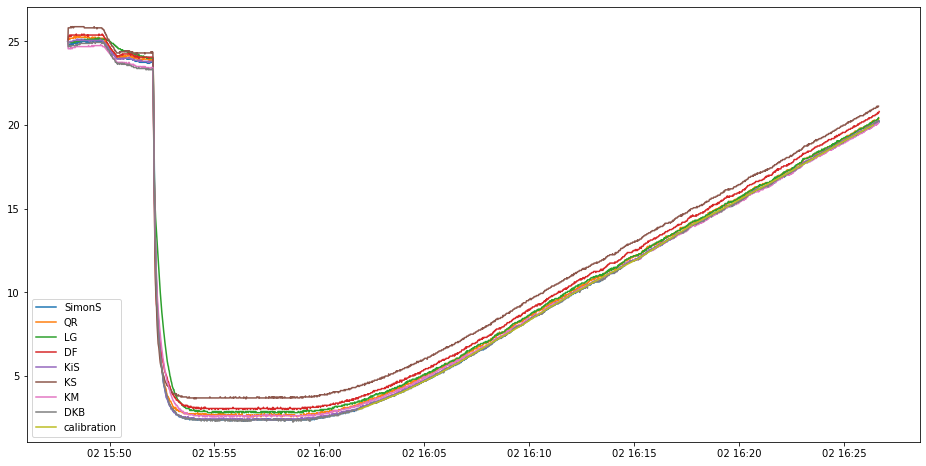

In [224]:
filenames = glob.glob("Tsensor_measurements/*.LOG")
print(filenames)

fig=plt.figure(figsize=(16,8))
path_storage = 'Tsensor_measurements/files_timeaxis/'
storage = ['SimonS.LOG', 'QR.LOG', 'LG.LOG', 'DF.LOG','KiS.LOG','KS.LOG','KM.LOG','DKB.LOG' ]

k=0
for filename in filenames:
    #load in all file by file
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    tsensor["time"] = pd.to_datetime(tsensor["time"], utc=True).dt.tz_localize(None)
    
    if (filename== filenames[2]) or (filename == filenames[6]):

        tsensor["time"] = tsensor["time"].copy()+DateOffset(years=23,months=2,days=1,hours=15,minutes=48)

        for i in range(0,len(tsensor["time"].values)):
            tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)
            
    #calculate offset to laboratoy measurement at shock time:
    print(filename.split("/")[-1].split("_")[-1].split(".")[0])
    offset = tsensor['time'].values[millis_start[k]]-start_shock
    print('shock time old:', tsensor['time'][millis_start[k]])
    print('offset: ', tsensor['time'][0] - offset)
    
    tsensor['time'] = tsensor['time']- offset
    
    #print the shock time:
    print('shock time: ', tsensor['time'][millis_start[k]])
        #tsensor["time"] = tsensor["time"]+DateOffset(years=23,months=2,days=1,hours=15,minutes=48)
    print('start time: ', tsensor['time'][0])
    
    plt.plot(tsensor['time'], tsensor['temperature'], label=filename.split("/")[-1].split("_")[-1].split(".")[0])
    
    
    
    
    tsensor.to_csv(path_storage + storage[k])
    k+=1
    
plt.plot(calibration_2['time'], calibration_2['temperature'], label='calibration')
plt.legend()
plt.show()

<AxesSubplot:xlabel='millis'>

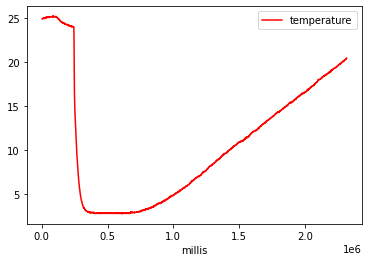

In [7]:
tsensor_lg.plot(x="millis", y="temperature", color='r')